# ABC calibration of $I_\text{Kur}$ in Courtemanche model to original dataset.

Note the term $I_\text{sus}$ for sustained outward Potassium current is used throughout the notebook.

In [6]:
import os, tempfile
import logging
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [7]:
from ionchannelABC import theoretical_population_size
from ionchannelABC import IonChannelDistance, EfficientMultivariateNormalTransition, IonChannelAcceptor
from ionchannelABC.experiment import setup
from ionchannelABC.visualization import plot_sim_results, plot_kde_matrix_custom
import myokit

In [8]:
from pyabc import Distribution, RV, History, ABCSMC
from pyabc.epsilon import MedianEpsilon
from pyabc.sampler import MulticoreEvalParallelSampler, SingleCoreSampler
from pyabc.populationstrategy import ConstantPopulationSize

## Initial set-up

Load experiments of unified dataset:
 - Steady-state activation [Wang1993]
 - Activation time constant [Wang1993]
 - Deactivation time constant [Courtemanche1998]
 - Steady-state inactivation [Firek1995]
 - Inactivation time constant [Nygren1998]
 - Recovery time constant [Nygren1998]

In [9]:
from experiments.isus_wang import wang_act_and_kin
from experiments.isus_courtemanche import courtemanche_deact
from experiments.isus_firek import firek_inact
from experiments.isus_nygren import (nygren_inact_kin,
                                     nygren_rec)

In [10]:
modelfile = 'models/courtemanche_isus.mmt'

Plot steady-state and tau functions of original model

In [11]:
from ionchannelABC.visualization import plot_variables

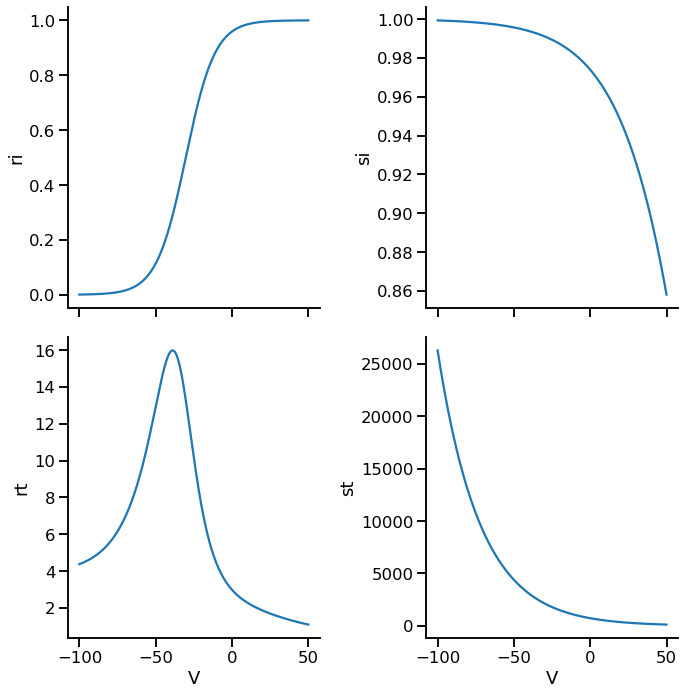

In [12]:
sns.set_context('talk')

V = np.arange(-100, 50, 0.01)

cou_par_map = {'ri': 'isus.a_inf',
            'si': 'isus.i_inf',
            'rt': 'isus.tau_a',
            'st': 'isus.tau_i'}

f, ax = plot_variables(V, cou_par_map, modelfile, figshape=(2,2))

# Activation gate ($a$) calibration

Combine model and experiments to produce:
 - observations dataframe
 - model function to run experiments and return traces
 - summary statistics function to accept traces

In [13]:
observations, model, summary_statistics = setup(modelfile,
                                                firek_inact,
                                                nygren_inact_kin,
                                                nygren_rec)

In [14]:
assert len(observations)==len(summary_statistics(model({})))

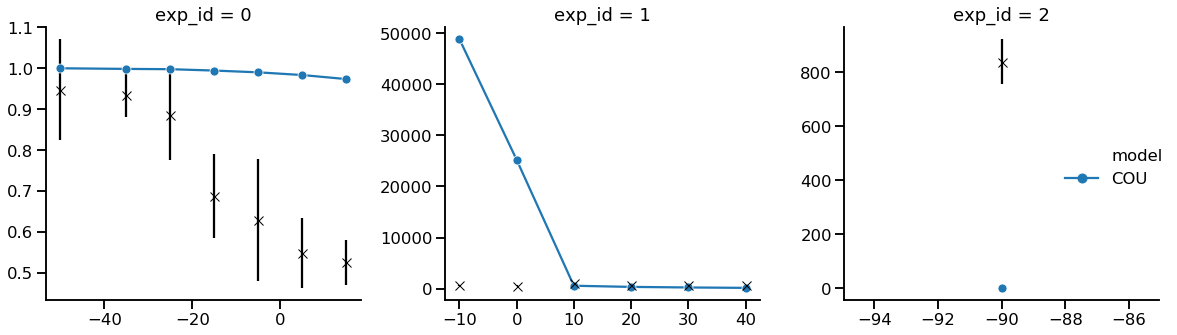

In [15]:
g = plot_sim_results(modelfile,
                     firek_inact,
                     nygren_inact_kin,
                     nygren_rec)

### Set up prior ranges for each parameter in the model.

See the modelfile for further information on specific parameters. Prepending `log_' has the effect of setting the parameter in log space.

In [16]:
limits = {'isus.q1': (-200, 200),
          'isus.q2': (1e-7, 50),
          'log_isus.q3': (-1, 4),
          'isus.q4': (-200, 200),
          'isus.q5': (1e-7, 50),
          'isus.q6': (-200, 0),
          'isus.q7': (1e-7, 50)}
prior = Distribution(**{key: RV("uniform", a, b - a)
                        for key, (a,b) in limits.items()})

In [17]:
# Test this works correctly with set-up functions
assert len(observations) == len(summary_statistics(model(prior.rvs())))

### Run ABC calibration

In [12]:
db_path = ("sqlite:///" + os.path.join(tempfile.gettempdir(), "courtemanche_isus_igate_unified.db"))

In [13]:
pop_size = theoretical_population_size(2, len(limits))
print("Theoretical minimum population size is {} particles".format(pop_size))

Theoretical minimum population size is 128 particles


In [14]:
abc = ABCSMC(models=model,
             parameter_priors=prior,
             distance_function=IonChannelDistance(
                 exp_id=list(observations.exp_id),
                 variance=list(observations.variance),
                 delta=0.05),
             population_size=ConstantPopulationSize(1000),
             summary_statistics=summary_statistics,
             transitions=EfficientMultivariateNormalTransition(),
             eps=MedianEpsilon(initial_epsilon=100),
             sampler=MulticoreEvalParallelSampler(n_procs=16),
             acceptor=IonChannelAcceptor())

In [15]:
obs = observations.to_dict()['y']
obs = {str(k): v for k, v in obs.items()}

In [16]:
abc_id = abc.new(db_path, obs)

INFO:History:Start <ABCSMC(id=4, start_time=2019-10-28 17:30:55.055210, end_time=None)>


In [ ]:
history = abc.run(minimum_epsilon=0., max_nr_populations=100, min_acceptance_rate=0.01)

INFO:ABC:t:0 eps:100
INFO:ABC:t:1 eps:3.779602733664772


### Analysis of results

In [18]:
history = History('sqlite:///results/courtemanche/isus/unified/courtemanche_isus_igate_unified.db')

In [20]:
history.all_runs() # most recent is the relevant run

[<ABCSMC(id=1, start_time=2019-10-24 06:56:23.812717, end_time=None)>,
 <ABCSMC(id=2, start_time=2019-10-24 09:09:37.536184, end_time=None)>,
 <ABCSMC(id=3, start_time=2019-10-24 09:48:05.512352, end_time=2019-10-24 14:08:03.995579)>,
 <ABCSMC(id=4, start_time=2019-10-28 17:30:55.055210, end_time=2019-10-28 21:22:51.027782)>]

In [21]:
df, w = history.get_distribution()

In [22]:
df.describe()

name,isus.q1,isus.q2,isus.q4,isus.q5,isus.q6,isus.q7,log_isus.q3
count,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000
mean,54.840032,39.952003,74.777367,3.560559,-147.586748,2.291974,2.828653
std,0.007372,0.003721,2.381931,0.557121,32.686898,1.453973,0.000009
min,54.817004,39.940597,72.274269,1.952086,-199.934864,0.003291,2.828628
25%,54.834979,39.949469,73.838877,3.559733,-172.862481,1.091292,2.828646
50%,54.840130,39.952032,74.057485,3.728989,-152.777588,2.078279,2.828653
75%,54.845476,39.954713,74.781496,3.780290,-125.387236,3.302738,2.828658
max,54.861326,39.962751,81.654981,4.145626,-55.434653,6.451547,2.828679


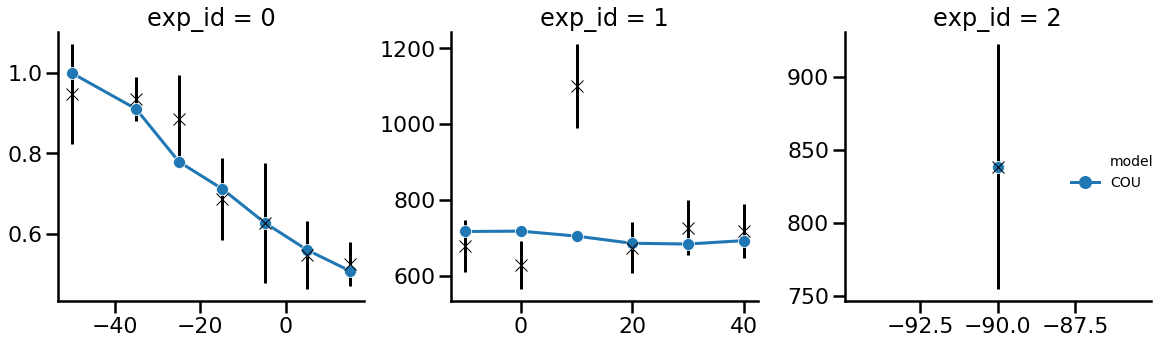

In [23]:
sns.set_context('poster')

mpl.rcParams['font.size'] = 14
mpl.rcParams['legend.fontsize'] = 14

g = plot_sim_results(modelfile,
                     firek_inact,
                    nygren_inact_kin,
                    nygren_rec,
                     df=df, w=w)

plt.tight_layout()

In [24]:
import pandas as pd
N = 100
cou_par_samples = df.sample(n=N, weights=w, replace=True)
cou_par_samples = cou_par_samples.set_index([pd.Index(range(N))])
cou_par_samples = cou_par_samples.to_dict(orient='records')

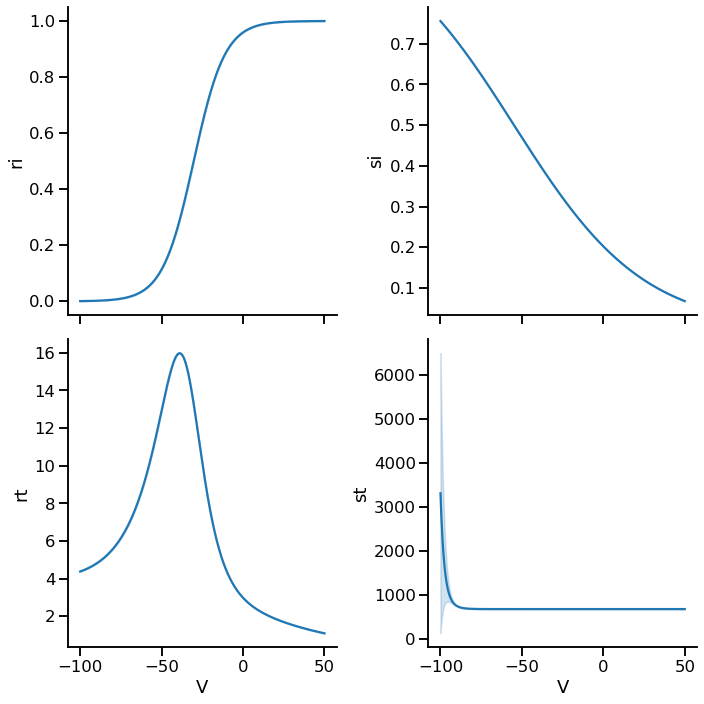

In [25]:
sns.set_context('talk')
mpl.rcParams['font.size'] = 14
mpl.rcParams['legend.fontsize'] = 14

f, ax = plot_variables(V, cou_par_map, 
                       'models/courtemanche_isus.mmt', 
                       [cou_par_samples],
                       figshape=(2,2))

plt.tight_layout()

In [26]:
m,_,_ = myokit.load(modelfile)

In [27]:
originals = {}
for name in limits.keys():
    if name.startswith("log"):
        name_ = name[4:]
    else:
        name_ = name
    val = m.value(name_)
    if name.startswith("log"):
        val_ = np.log10(val)
    else:
        val_ = val
    originals[name] = val_

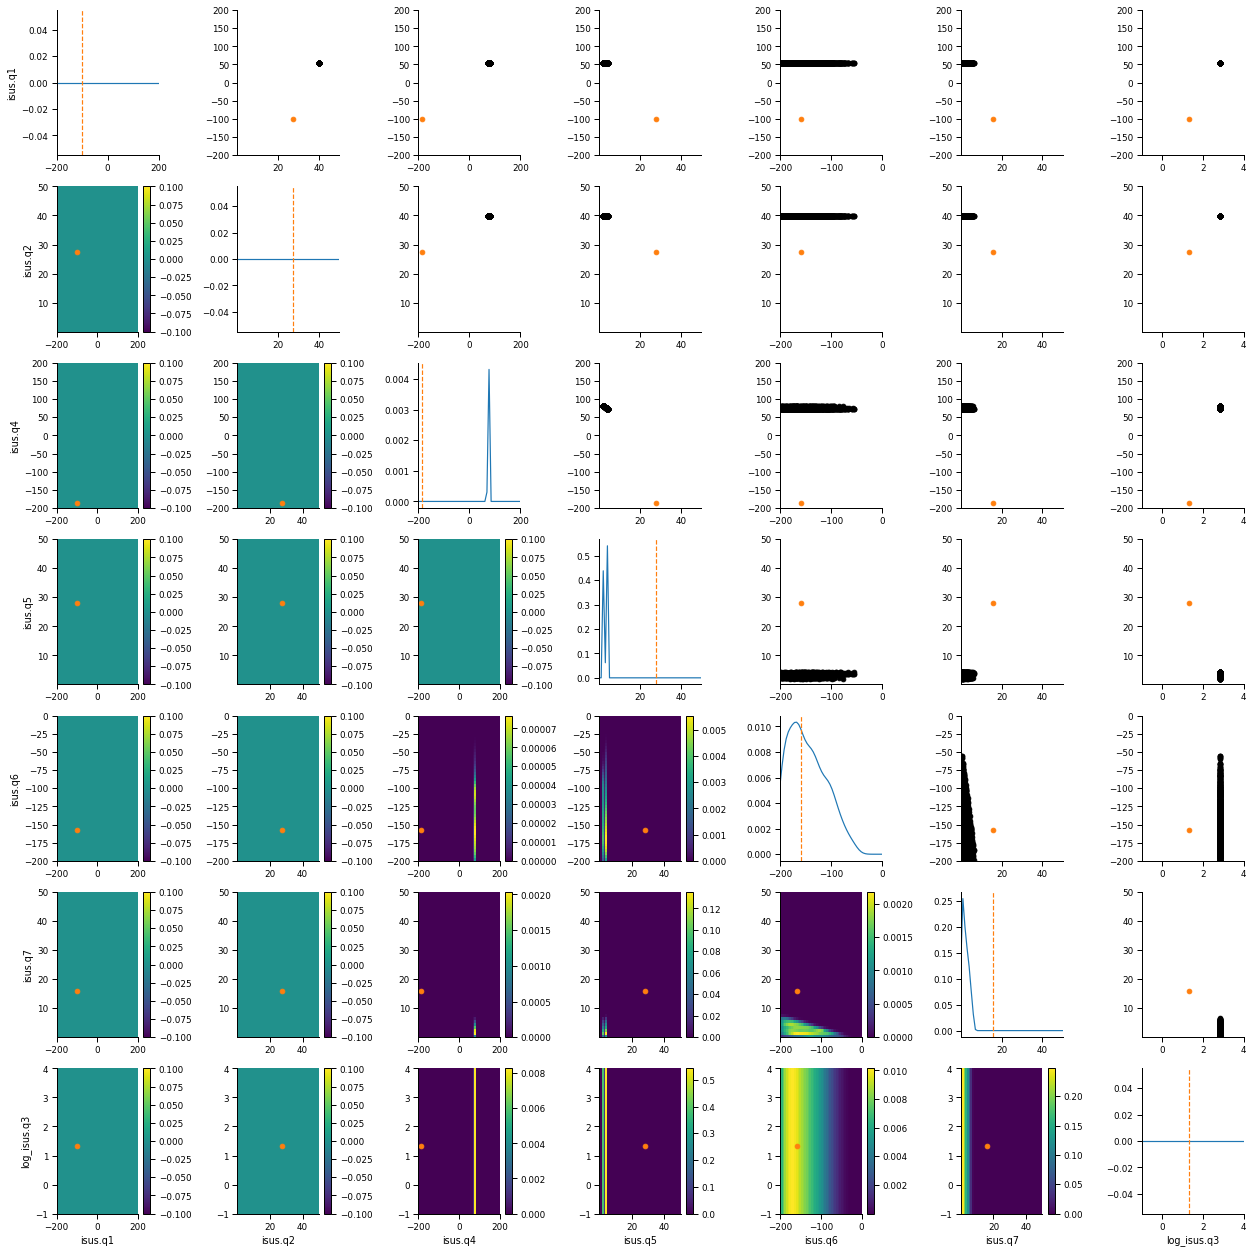

In [28]:
sns.set_context('paper')
g = plot_kde_matrix_custom(df, w, limits=limits, refval=originals)
plt.tight_layout()